In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scvi
import scanpy as sc
import anndata as an
import scanpy.external as sce
import scipy
import scipy.sparse as sp
import gget
import time
import sklearn
import torch
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, cdist, squareform
import sklearn.metrics as sm

from importlib import reload

# local imports
import utils as ut
import plotting as plt2

sc.settings.verbosity = 3 

In [2]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/SCANVI/imputed_data.h5ad"
adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()
print(adata)

Memory usage: current 6.17 GB, difference +6.17 GB
AnnData object with n_obs × n_vars = 86725 × 7500
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'batch'
    uns: 'batch_colors', 'dataset_colors', 'neighbors', 'standard_cell_type_colors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'SCANVI_counts', 'counts', 'log_norm'
    obsp: 'connectivities', 'distances'


In [3]:
sorted(adata.var.index)[-10:]

['ZSCAN30',
 'ZSWIM2',
 'ZSWIM4',
 'ZSWIM5',
 'ZSWIM6',
 'ZSWIM7',
 'ZSWIM8',
 'ZXDB',
 'ZYX',
 'ZZEF1']

In [4]:
# load the obs annotations
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/obs/merged_scfib_obs.csv"
obs = pd.read_csv(fpath)
cluster_map = dict(zip(obs['cell_id'].values, obs['cluster_str'].values))

adata.obs['cluster_str'] = adata.obs.index.map(cluster_map)
adata.obs['cluster_str'].value_counts()

cluster_str
C1    3855
C2    1688
C3    1521
C4     602
C5     443
C6      22
Name: count, dtype: int64

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:28)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:55)
running Leiden clustering


/tmp/ipykernel_2863636/2550095663.py:13: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


    finished: found 24 clusters and added
    'scanvi_cluster', the cluster labels (adata.obs, categorical) (0:00:12)


... storing 'cluster_str' as categorical


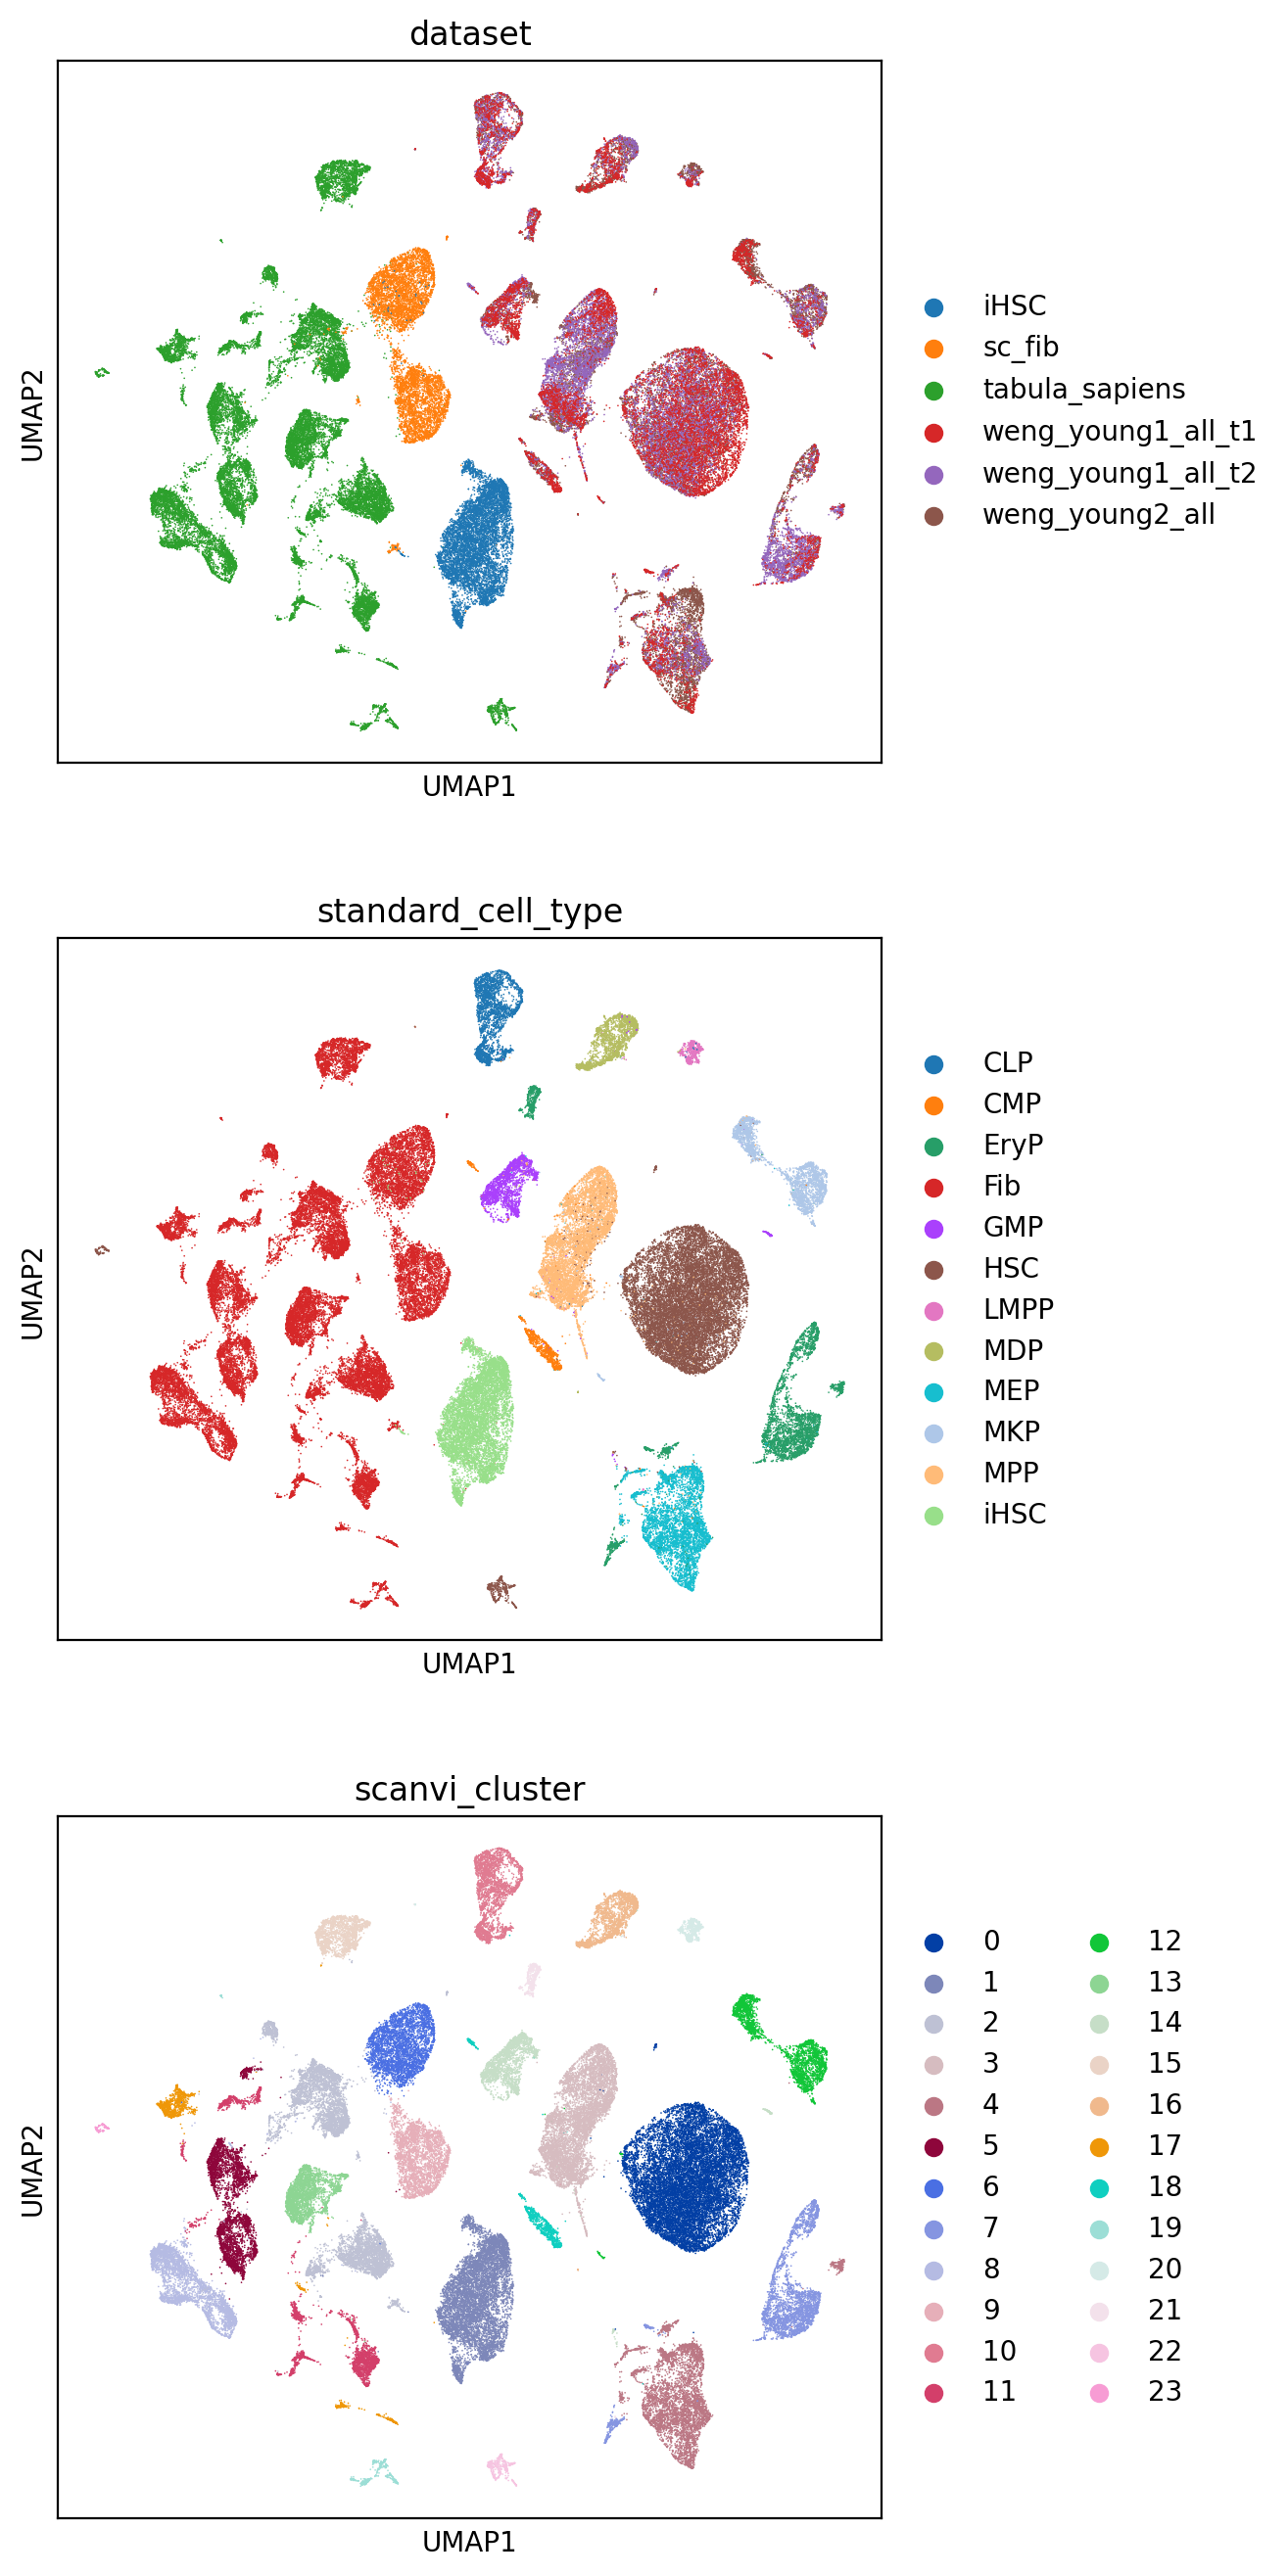

In [5]:
sc.pp.neighbors(
    adata, 
    use_rep='X_scANVI',
)

sc.tl.umap(
    adata,
    min_dist=0.15,
    spread=2.0,
    # method='rapids',
)

sc.tl.leiden(
    adata,
    resolution=0.25,
    key_added='scanvi_cluster',
)

adata.obs['scANVI_UMAP_1'] = adata.obsm['X_umap'][:, 0]
adata.obs['scANVI_UMAP_2'] = adata.obsm['X_umap'][:, 1]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sc.pl.umap(
    adata, 
    color=[
        'dataset',
        'standard_cell_type',
        'scanvi_cluster',
    ],
    ncols=1,
)

# Nice plots

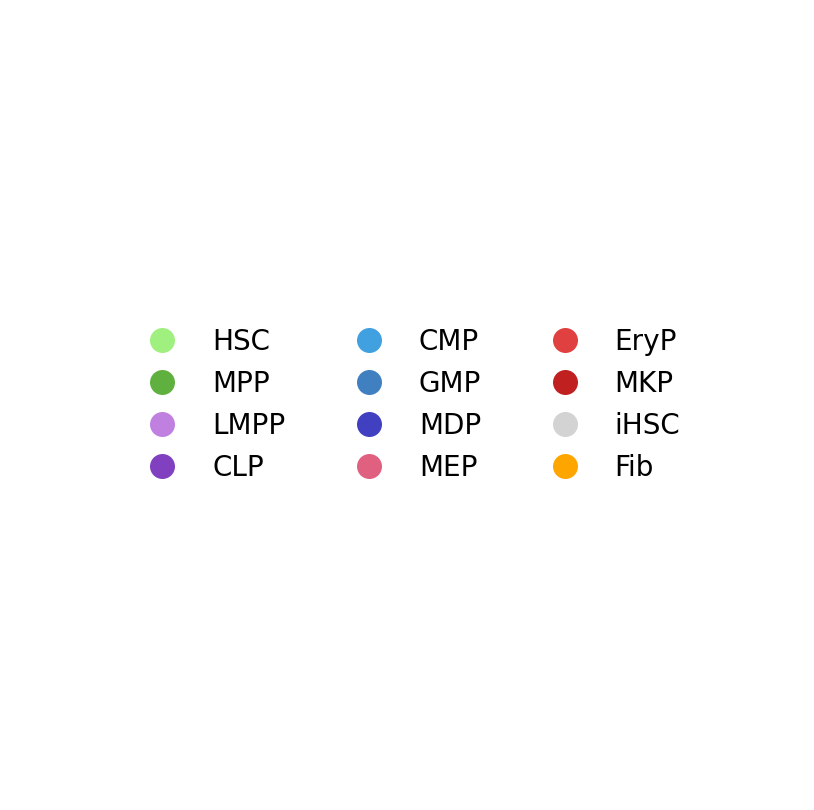

In [6]:
cell_colors = {
    # Stem cells (green shades)
    'HSC': '#a0f080',  # Light green for hematopoietic stem cell
    'MPP': '#60b040',  # Darker green for multipotent progenitor

    # Lymphoid lineage (shades of purple)
    'LMPP': '#c080e0',  # Light purple
    'CLP': '#8040c0',  # Darker purple

    # Myeloid lineage (shades of blue)
    'CMP': '#40a0e0',  # Medium blue for common myeloid progenitor
    'GMP': '#4080c0',  # Darker blue for granulocyte-monocyte progenitor
    'MDP': '#4040c0',  # A distinct blue 

    # Erythroid/Megakaryocyte in reds (branching from myeloid)
    'MEP': '#e06080',  # Lighter red (leaning towards orange) 
    'EryP': '#e04040',  # Bright red
    'MKP': '#c02020',  # Dark red

    'iHSC': 'lightgrey',  # Slightly darker green for inactive HSC
    
    # Fibroblast in orange
    'Fib': '#ffa500'   # Orange
}

fig, ax = plt.subplots()  # Create a figure and an axes object

handles = [plt.Line2D([0], [0], marker='o', color='w', label=cell_type, 
                      markerfacecolor=color, markersize=10) 
           for cell_type, color in cell_colors.items()]

ax.legend(
    handles=handles, 
    title='', 
    frameon=False,
    ncols=3,
    loc='center') 
ax.axis('off')  

plt.show()

,n_genes,dataset,n_genes_by_counts,total_counts,obs_index,cell_type,standard_cell_type,cell_label,_scvi_batch,_scvi_labels,batch,cluster_str,scanvi_cluster,scANVI_UMAP_1,scANVI_UMAP_2,cell_type_color
AAAGCAAGTTGGTTCT-2_weng_young1_all_t2,1026,weng_young1_all_t2,1026,6920.248650,AAAGCAAGTTGGTTCT-2,CLP,CLP,CLP,1,0,0,NaN,10,10.135634,24.442854,#8040c0
AGCTCATAGTTAACCA-2_weng_young1_all_t2,1562,weng_young1_all_t2,1562,9806.586380,AGCTCATAGTTAACCA-2,CLP,CLP,CLP,1,0,0,NaN,10,9.686961,24.525860,#8040c0
AGCTCATAGAATCGCT-2_weng_young1_all_t2,1366,weng_young1_all_t2,1366,8780.007173,AGCTCATAGAATCGCT-2,CLP,CLP,CLP,1,0,0,NaN,10,8.949826,23.257488,#8040c0
AGCTATATCCGTAAAC-2_weng_young1_all_t2,1205,weng_young1_all_t2,1205,7847.754563,AGCTATATCCGTAAAC-2,CLP,CLP,CLP,1,0,0,NaN,10,8.896288,19.922138,#8040c0
AGCTAGTTCTCCATAT-2_weng_young1_all_t2,1313,weng_young1_all_t2,1313,8492.922729,AGCTAGTTCTCCATAT-2,CLP,CLP,CLP,1,0,0,NaN,10,8.918976,23.689482,#8040c0


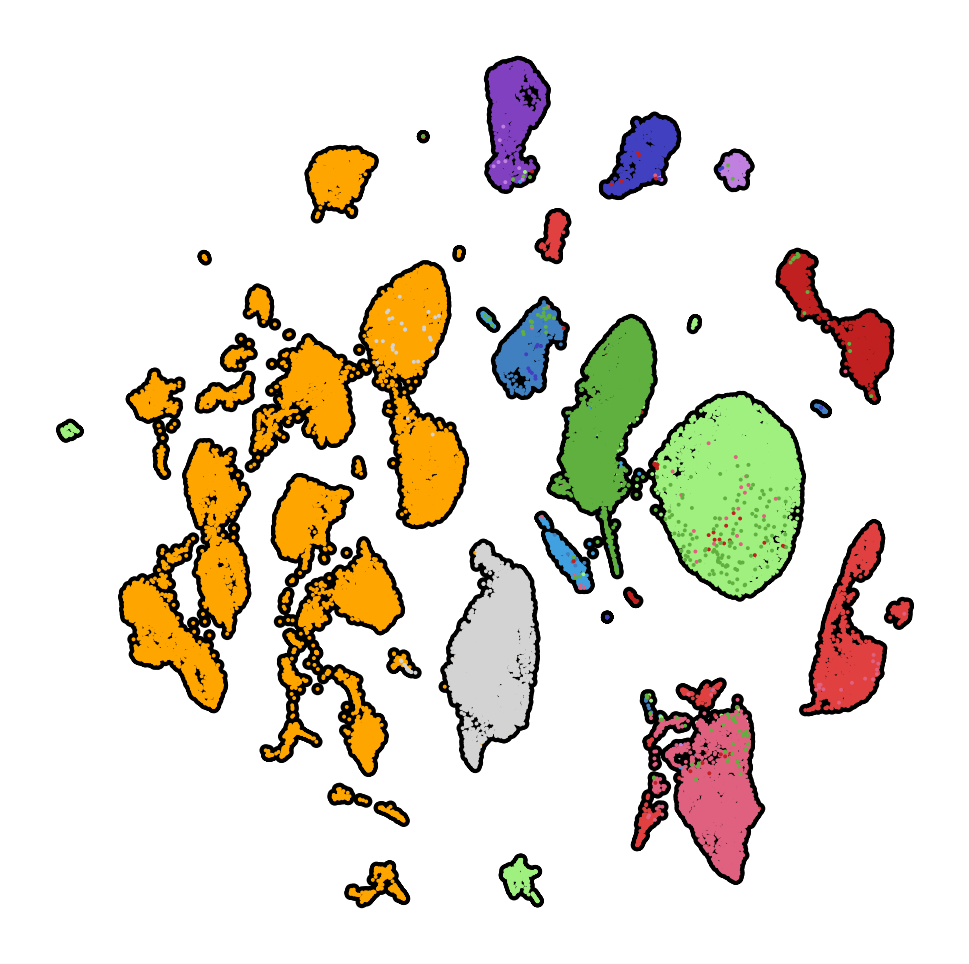

In [7]:
pdf = adata.obs.copy()
pdf = pdf.sort_values(by='standard_cell_type')
pdf['cell_type_color'] = pdf['standard_cell_type'].map(cell_colors)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

sns.scatterplot(
    data=pdf,
    x='scANVI_UMAP_1',
    y='scANVI_UMAP_2',
    ec='none',
    s=20,
    c='k',
)

sns.scatterplot(
    data=pdf,
    x='scANVI_UMAP_1',
    y='scANVI_UMAP_2',
    ec='none',
    s=2,
    c=pdf['cell_type_color'].values,
)

plt.xticks([])
plt.yticks([])

plt.ylabel('UMAP 2')
plt.xlabel('UMAP 1')
plt.gca().set_aspect('auto')
plt.axis(False)


pdf.head()

,n_genes,dataset,n_genes_by_counts,total_counts,obs_index,cell_type,standard_cell_type,cell_label,_scvi_batch,_scvi_labels,batch,cluster_str,scanvi_cluster,scANVI_UMAP_1,scANVI_UMAP_2,cell_type_color
AAAGCAAGTTGGTTCT-2_weng_young1_all_t2,1026,weng_young1_all_t2,1026,6920.248650,AAAGCAAGTTGGTTCT-2,CLP,CLP,CLP,1,0,0,NaN,10,10.135634,24.442854,#8040c0
AGCTCATAGTTAACCA-2_weng_young1_all_t2,1562,weng_young1_all_t2,1562,9806.586380,AGCTCATAGTTAACCA-2,CLP,CLP,CLP,1,0,0,NaN,10,9.686961,24.525860,#8040c0
AGCTCATAGAATCGCT-2_weng_young1_all_t2,1366,weng_young1_all_t2,1366,8780.007173,AGCTCATAGAATCGCT-2,CLP,CLP,CLP,1,0,0,NaN,10,8.949826,23.257488,#8040c0
AGCTATATCCGTAAAC-2_weng_young1_all_t2,1205,weng_young1_all_t2,1205,7847.754563,AGCTATATCCGTAAAC-2,CLP,CLP,CLP,1,0,0,NaN,10,8.896288,19.922138,#8040c0
AGCTAGTTCTCCATAT-2_weng_young1_all_t2,1313,weng_young1_all_t2,1313,8492.922729,AGCTAGTTCTCCATAT-2,CLP,CLP,CLP,1,0,0,NaN,10,8.918976,23.689482,#8040c0


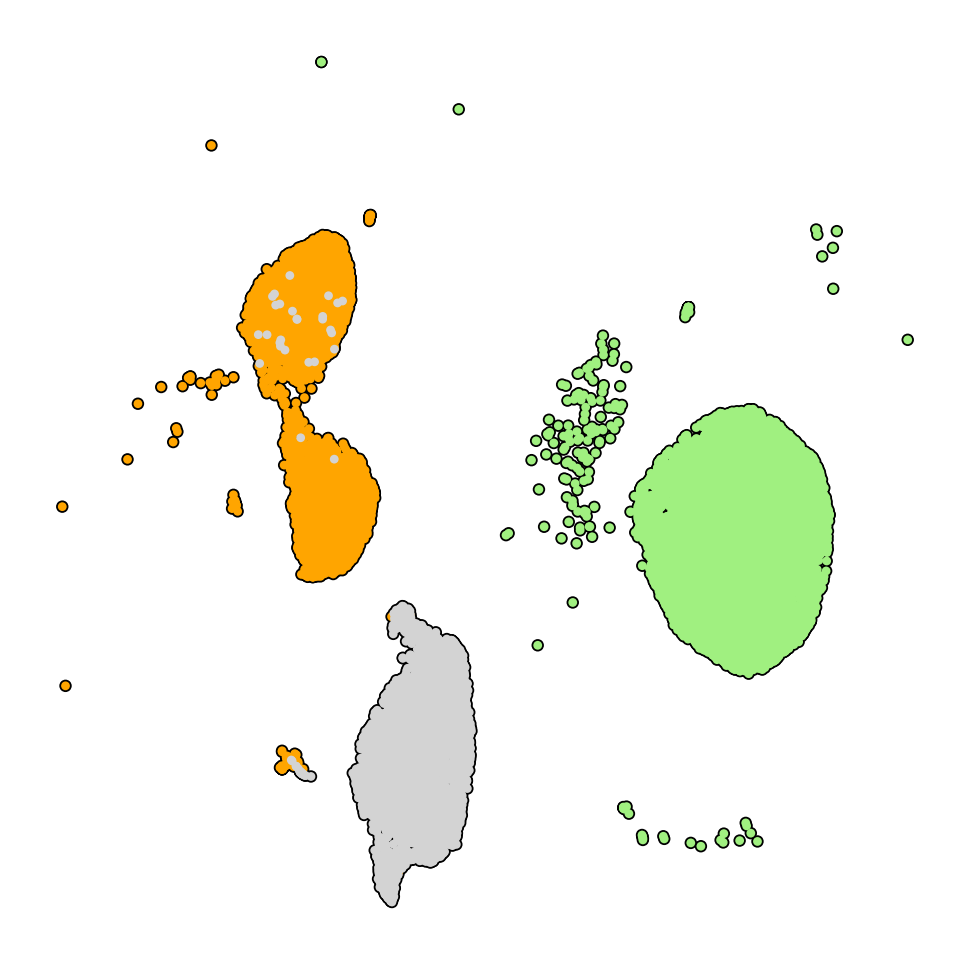

In [8]:
pdf = adata.obs.copy()
pdf = pdf.sort_values(by='standard_cell_type')
pdf['cell_type_color'] = pdf['standard_cell_type'].map(cell_colors)

keep_types = [
    'iHSC',
    'Fib',
    'HSC',
]

exclude_datasets = [
    'tabula_sapiens',
]

mask = (pdf['standard_cell_type'].isin(keep_types)) & (~pdf['dataset'].isin(exclude_datasets))

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

sns.scatterplot(
    data=pdf[mask],
    x='scANVI_UMAP_1',
    y='scANVI_UMAP_2',
    ec='none',
    s=20,
    c='k',
)

sns.scatterplot(
    data=pdf[mask],
    x='scANVI_UMAP_1',
    y='scANVI_UMAP_2',
    ec='none',
    s=10,
    c=pdf[mask]['cell_type_color'].values,
)

plt.xticks([])
plt.yticks([])

plt.ylabel('UMAP 2')
plt.xlabel('UMAP 1')
plt.gca().set_aspect('auto')
plt.axis(False)

pdf.head()

computing density on 'umap'
--> added
    'umap_density', densities (adata.obs)
    'umap_density_params', parameter (adata.uns)


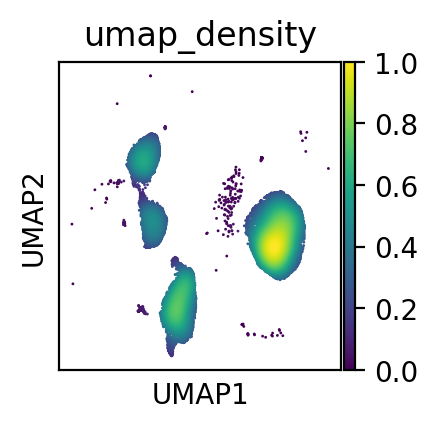

In [9]:
keep_types = [
    'iHSC',
    'Fib',
    'HSC',
]

exclude_datasets = [
    'tabula_sapiens',
]

mask = (adata.obs['standard_cell_type'].isin(keep_types)) & (~adata.obs['dataset'].isin(exclude_datasets))

bdata = adata[mask, :].copy()
bdata.obsm['X_scanvi'] = bdata.obsm['X_scANVI'].copy()
sc.tl.embedding_density(bdata, basis='umap')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 2

sc.pl.umap(
    bdata, 
    color=['umap_density'],
)

# Distances

In [10]:
init = adata[adata.obs['dataset'] == 'sc_fib', :].copy()
target = adata[adata.obs['standard_cell_type'] == 'HSC', :].copy()
ihsc = adata[adata.obs['standard_cell_type'] == 'iHSC', :].copy()

X_init = init.obsm['X_scANVI']
X_target = target.obsm['X_scANVI']
X_ihsc = ihsc.obsm['X_scANVI']

print(f"{X_init.shape=}")
print(f"{X_target.shape=}")
print(f"{X_ihsc.shape=}")

X_init.shape=(7315, 12)
X_target.shape=(14639, 12)
X_ihsc.shape=(8131, 12)


In [11]:
metric = 'cosine'

D_target = cdist(X_ihsc, X_target, metric)
D_init = cdist(X_ihsc, X_init, metric)

ddf = pd.DataFrame({
    'cell_id' : ihsc.obs_names,
    'mean_target' : D_target.mean(axis=1),
    'min_target' : D_target.min(axis=1),
    'max_target' : D_target.max(axis=1),
    'mean_init' : D_init.mean(axis=1),
    'min_init' : D_init.min(axis=1),
    'max_init' : D_init.max(axis=1),
})
ddf['cluster'] = ddf['cell_id'].map(cluster_map)
ddf.head()

,cell_id,mean_target,min_target,max_target,mean_init,min_init,max_init,cluster,metric
0,AAACCCAAGGTTACCT_iHSC,0.649651,0.194198,1.253420,0.761909,0.102983,1.323976,C1,cosine
1,AAACCCAAGTTGAAGT_iHSC,0.706814,0.263243,1.279880,0.774158,0.203113,1.268035,C1,cosine
2,AAACCCAAGTTGTCGT_iHSC,0.846730,0.364187,1.586008,0.723926,0.065195,1.442680,C4,cosine
3,AAACCCACAGAAGCGT_iHSC,0.703824,0.223557,1.397898,0.770026,0.074146,1.374769,C2,cosine
4,AAACCCACAGGAGGTT_iHSC,0.751600,0.210269,1.401475,0.753669,0.105332,1.376812,C1,cosine


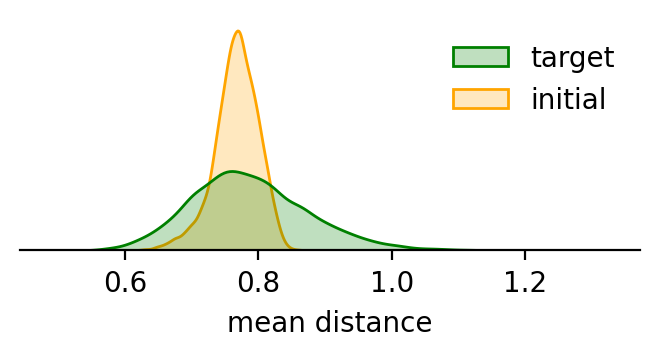

In [12]:
pdf = ddf.copy()

pdf = pd.melt(
    pdf, 
    id_vars='cell_id', 
    value_vars=['mean_target', 'mean_init'],
)

label_map = {
    'mean_target' : 'target',
    'mean_init' : 'initial',
}

pdf['label'] = pdf['variable'].map(label_map)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 1.5

sns.kdeplot(
    data=pdf,
    # bins=31,
    x='value',
    hue='label',
    fill=True,
    # kde='True',
    # palette=['#a0f080', '#ffa500'],
    # palette = ['#80e040', '#ff8000'],
    palette = ['green', 'orange']

)

plt.xlabel("mean distance")
plt.ylabel("")
plt.yticks([])

sns.move_legend(
    plt.gca(),
    title="",
    loc='best',
    frameon=False,
)

sns.despine(left=True)

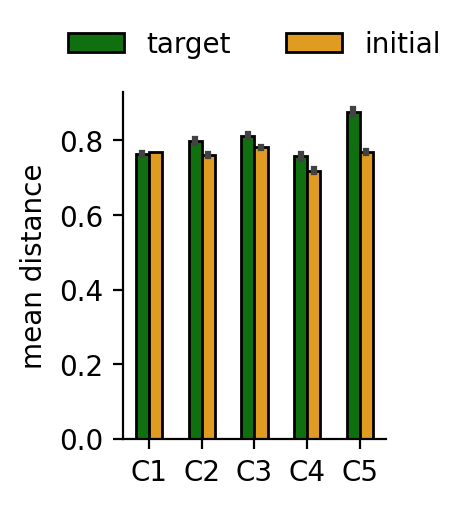

In [13]:
pdf = ddf.copy()

pdf = pd.melt(
    pdf, 
    id_vars=['cell_id', 'cluster'], 
    value_vars=['mean_target', 'mean_init'],
)

pdf = pdf[pdf['cluster'] != 'C6']

label_map = {
    'mean_target' : 'target',
    'mean_init' : 'initial',
}

pdf['label'] = pdf['variable'].map(label_map)
pdf = pdf.sort_values(by='cluster')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.7, 2.25

sns.barplot(
    data=pdf,
    x='cluster',
    y='value',
    hue='label',
    width=0.5,
    ec='k',
    palette = ['green', 'orange'],
)

plt.ylabel("mean distance")
plt.xlabel("")

sns.move_legend(
    plt.gca(),
    title="",
    loc='upper center',
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, 1.25)
)

sns.despine()

In [14]:
# break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Sort by distance

In [15]:
reload(ut)
fpath = "../resources/CellMarker_2024.txt"
features = ut.load_pathway(fpath)

[x for x in features.columns if 'hemato' in x.lower()]

pathway = "Hematopoietic Stem Cell Bone Marrow Human"
# pathway = "Bone Marrow-hematopoietic Stem Cell"
# pathway = 'Hematopoietic Stem Cells'
# pathway = 'Fibroblasts'
query_genes = list(features[features[pathway]].index)
print(len(query_genes))
query_genes[:10]

62


['BMI1',
 'CD38',
 'IL7R',
 'THY1',
 'PTPRC',
 'PECAM1',
 'CD34',
 'CD44',
 'NGFR',
 'VCAM1']

In [16]:
pdf = ddf.copy()
pdf = pdf.sort_values(by='mean_target')

# sort expression by distance
exp_df = bdata.to_df(layer='SCANVI_counts')
exp_df = exp_df.loc[pdf['cell_id'].values]
print(f"{exp_df.shape=}")
exp_df['rank'] = range(len(exp_df))
exp_df.head()

exp_df.shape=(8131, 7500)


gene_name,A1BG,A2M,A2ML1,A3GALT2,AADAT,AAK1,AAMDC,AAR2,AASS,AATK,...,ZSWIM2,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZSWIM8,ZXDB,ZYX,ZZEF1,rank
GGACGTCTCGCATTGA_iHSC,0.000194,0.000019,0.000592,0.000040,0.000047,0.000037,0.000001,0.000082,0.000028,0.000003,...,0.000024,0.000151,0.000009,0.000301,0.000003,0.000015,0.000003,0.000027,7.790203e-07,0
GTCTACCAGCTCGTGC_iHSC,0.000199,0.000013,0.000200,0.000059,0.000084,0.000003,0.000002,0.000100,0.000031,0.000003,...,0.000023,0.000141,0.000016,0.001006,0.000006,0.000017,0.000004,0.000030,1.682460e-06,1
AGCATCAAGAGCCATG_iHSC,0.000198,0.000029,0.000527,0.000054,0.000048,0.000037,0.000002,0.000116,0.000034,0.000004,...,0.000040,0.000151,0.000014,0.000404,0.000005,0.000017,0.000004,0.000038,1.092824e-06,2
TGTTGGATCGGAAACG_iHSC,0.000226,0.000012,0.000183,0.000043,0.000055,0.000004,0.000002,0.000090,0.000025,0.000003,...,0.000019,0.000126,0.000012,0.000877,0.000005,0.000015,0.000004,0.000025,1.486958e-06,3
TCGGTCTGTGTACGCC_iHSC,0.000170,0.000012,0.000335,0.000045,0.000044,0.000021,0.000001,0.000084,0.000026,0.000002,...,0.000020,0.000173,0.000010,0.000347,0.000003,0.000015,0.000003,0.000024,8.744517e-07,4


In [26]:
results = []

for column in exp_df.columns:
  if column != 'rank':  # Exclude the distance column itself
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
        exp_df['rank'], 
        exp_df[column],
    )
    results.append({
        'gene_name': column, 
        'intercept' : intercept,
        'r_value': r_value,
        'p_value': p_value,
        'slope': slope,
        'std_err' : std_err,
    })

results = pd.DataFrame(results)
print(f"{results.shape=}")
results = results.sort_values(by='slope')
# results = results[results['gene_name'].isin(query_genes)]
results.head(15)

results.shape=(7500, 6)


,gene_name,intercept,r_value,p_value,slope,std_err
3030,IL4I1,0.015055,-0.201842,1.661056e-75,-2.671385e-07,1.437719e-08
531,ATG12,0.022683,-0.059941,6.337430e-08,-1.892779e-07,3.496052e-08
4903,PRG2,0.002765,-0.319085,7.897685e-192,-1.158641e-07,3.816868e-09
2389,FSTL1,0.002682,-0.277210,2.299318e-143,-1.033826e-07,3.974270e-09
7223,ZFP82,0.002957,-0.266032,8.953056e-132,-8.980449e-08,3.609157e-09
3821,MINDY1,0.018532,-0.060322,5.225233e-08,-8.527525e-08,1.565085e-08
4645,PIGC,0.001812,-0.299987,1.018334e-168,-4.399956e-08,1.551849e-09
3385,LAMP2,0.002917,-0.225425,3.410644e-94,-4.178296e-08,2.002874e-09
6806,TSPAN9,0.008428,-0.079751,5.946478e-13,-4.039444e-08,5.599894e-09
7331,ZNF418,0.003082,-0.119528,2.914657e-27,-3.932111e-08,3.622524e-09


In [23]:
# database = 'ontology'
# n_genes = 50
# top_genes = results['gene_name'].head(n_genes)
# top_genes = list(top_genes)

# edf = gget.enrichr(top_genes, database=database)
# pd.set_option('display.max_colwidth', 100) 
# edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(15)

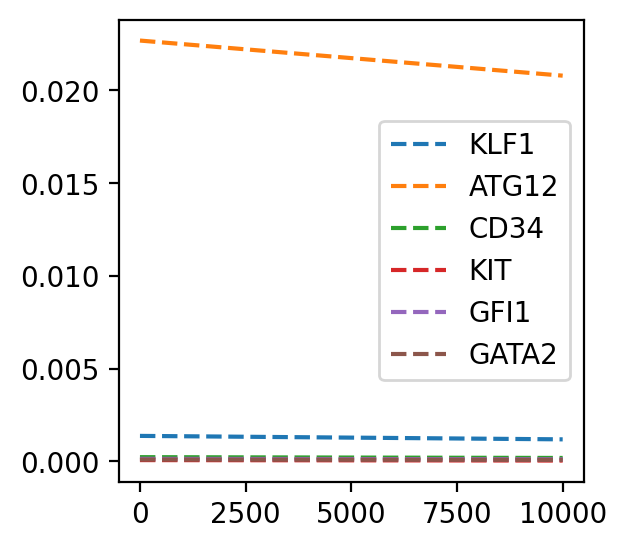

In [41]:
gene_list = [
    'KLF1',
    'ATG12',
    'CD34',
    'KIT',
    'GFI1',
    'GATA2'
]


def abline(slope, intercept):
  """Plot a line from slope and intercept"""
  x_vals = np.linspace(0, 10000)
  y_vals = intercept + slope * x_vals
  plt.plot(x_vals, y_vals, ls='--', zorder=5)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

for i, g in enumerate(gene_list):
    
    slope = results[results['gene_name'] == g]['slope'].values[0]
    intercept = results[results['gene_name'] == g]['intercept'].values[0]
    x_vals = np.linspace(0, 10000)
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, ls='--', label=g, zorder=5)


plt.legend()

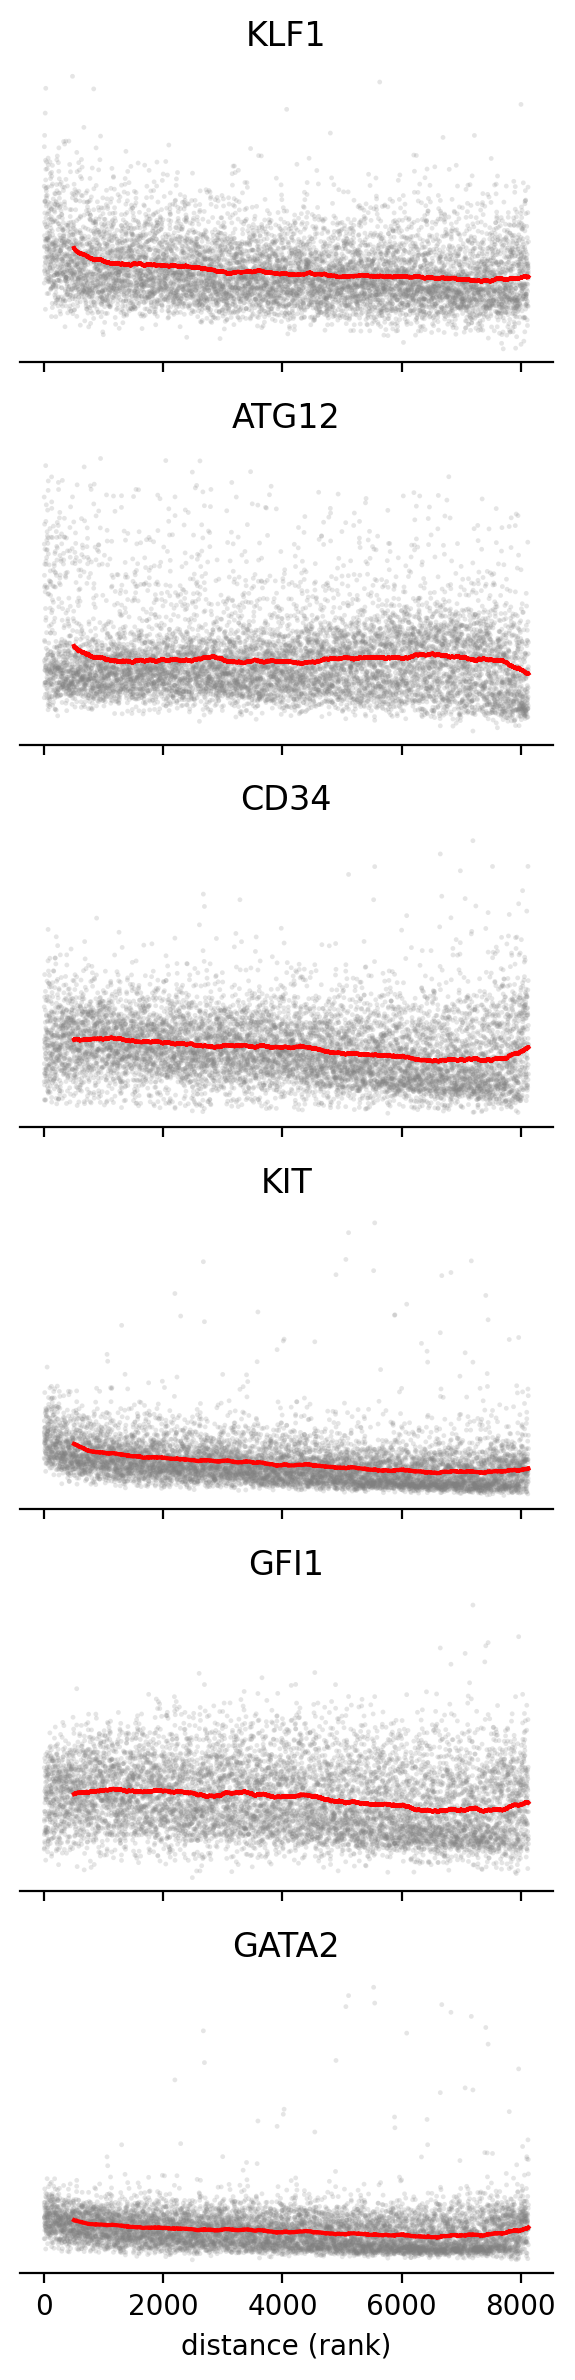

In [34]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 12

fig, axs = plt.subplots(6, 1, sharex=True)
axs = axs.ravel()

gene_list = [
    'KLF1',
    'ATG12',
    'CD34',
    'KIT',
    'GFI1',
    'GATA2'
]


def abline(ax, slope, intercept):
  """Plot a line from slope and intercept"""
  x_vals = np.array(ax.get_xlim())
  y_vals = intercept + slope * x_vals
  ax.plot(x_vals, y_vals, c='b', ls='--', zorder=5)

window = 500

for i, g in enumerate(gene_list):
    scaler = MinMaxScaler()  
    normed = scaler.fit_transform(exp_df[g].values.reshape(-1, 1)).flatten()
    smoothed = np.convolve(normed, np.ones(window), 'valid')
    rolling_avg = smoothed / window
    nan_padding = np.full(window - 1, np.nan)
    smoothed = np.concatenate((nan_padding, rolling_avg))
    
    sns.scatterplot(
        data=exp_df, 
        x='rank',
        y=normed,
        c='grey',
        alpha=0.2,
        s=3,
        ec='none',
        ax=axs[i],
    )
    
    sns.lineplot(
        data=exp_df, 
        x='rank',
        y=smoothed,
        c='r',
        ax=axs[i],
    )
    
    axs[i].set_title(g)
    axs[i].set_xlabel('distance (rank)')
    axs[i].set_ylabel('')
    axs[i].set_yticks([])

sns.despine(left=True)
plt.tight_layout()

# Predictions

In [ ]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/SCANVI/ihsc_predictions.csv"

pred = pd.read_csv(fpath)
pred['cluster'] = pred['cell_id'].map(cluster_map)
pred = pred[pred['cluster'] != 'C6']

pred = pd.pivot_table(
    pred, 
    index='cluster',
    columns='prediction',
    values='cell_id',
    aggfunc='count',
    fill_value=0.0,
)

pred = pred.div(pred.sum(axis=1), axis=0) * 100

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 4

sns.heatmap(
    data=pred,
    lw=1,
    annot=True,
    square=True,
    cbar=False,
    fmt=".2f",
    annot_kws={'fontsize' : 8},
    vmax=5,
    cmap='viridis_r',
)

plt.gca().tick_params(axis='y', rotation=0)
plt.ylabel("")
plt.xlabel("")



# Visualize expression

In [ ]:
def plot_gene_expression(exp_df, pdf, gene, cmap='viridis', vmin=None, vmax=None, ax=None, colorbar=True):
    """
    Plots gene expression on UMAP coordinates with color gradient.

    Args:
        exp_df: DataFrame containing gene expression data.
        pdf: DataFrame containing UMAP coordinates.
        gene: The gene to plot.
    """
    vector = exp_df[gene].values
    sorted_idx = np.argsort(vector)
    if vmax is None:
        vmax = vector.max()
    if vmin is None:
        vmin = vector.min()

    print(f"{vmax=:.5f} {vmin=:.5f}")
    if ax is None:
        fig, ax = plt.subplots()

    # Base scatterplot (black dots)
    sns.scatterplot(
        data=pdf,
        x='scANVI_UMAP_1',
        y='scANVI_UMAP_2',
        ec='k',
        color='k',
        s=25,
        zorder=1,
        ax=ax,
    )

    # Expression-colored scatterplot
    sns.scatterplot(
        data=pdf.iloc[sorted_idx],
        x='scANVI_UMAP_1',
        y='scANVI_UMAP_2',
        ec='none',
        hue=vector[sorted_idx],
        palette=cmap,
        s=8,
        zorder=1,
        hue_norm=(vmin, vmax),
        legend=False,
        ax=ax,
    )

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title(gene)
    sns.despine(left=True, bottom=True)


    if colorbar:
        # Create colorbar
        norm = plt.Normalize(vmin, vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # This is necessary for the colorbar to work

        # Add colorbar to the plot
        cbar = ax.figure.colorbar(sm, ax=ax, shrink=0.45)
    
    plt.axis('auto')

In [ ]:
gene_list = [
    # 'AVP',
    # 'CRHBP',
    'CD34',
    
]

layer = 'SCANVI_counts'
density_thr = 0.05

pdf = bdata.obs.copy()
mask = pdf['umap_density'] > density_thr
exp_df = bdata[:, gene_list].to_df(layer=layer)

for gene in gene_list:
    print(f"==== {gene} ====")
    stat = exp_df[mask][gene].describe(percentiles=[0.1, 0.5, 0.53, 0.9, 0.95, 0.99])
    # print(stat)
    # print()

    vmax = stat.loc['53%']

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 6, 3

    plot_gene_expression(
        exp_df[mask], 
        pdf[mask], 
        gene, 
        vmin=0,
        vmax=vmax,
        cmap='viridis', 
        colorbar=False,
    )

    break

In [ ]:
break